In [1]:
# Generate NEST target code from NESTML files

# from pynestml.frontend.pynestml_frontend import generate_nest_target

# nestml_file_path = "/home/shimoura/Documents/GitHub/motor-controller-model/nestml-neurons/"
# nestml_target_path = nestml_file_path + "nestml_target"

# generate_nest_target(input_path=nestml_file_path,
#                      target_path=nestml_target_path,)


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Testing rb_neuron with desired rate=40.0 Hz and sdev=15.0

Jun 25 18:25:44 Install [Info]: 
    loaded module nestmlmodule

Jun 25 18:25:44 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jun 25 18:25:44 rb_neuron [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Jun 25 18:25:44 basic_neuron [Warning]: 
    Simulation resolution has changed. Internal state and pa

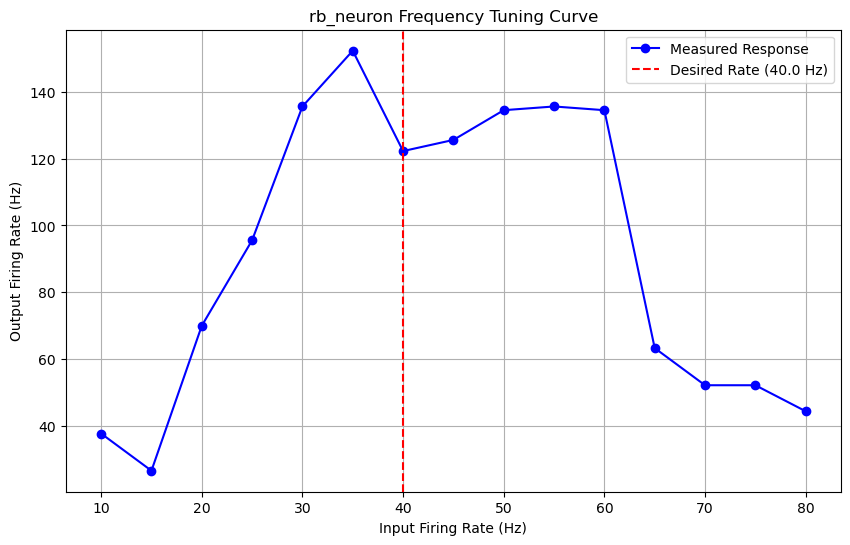

In [2]:
import nest
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup ---
nest.ResetKernel()
try:
    nest.Install("nestmlmodule")
except nest.NESTError:
    exit()

sim_time = 1000.0
resolution = 1.0
nest.resolution = resolution
neuron_sim_steps = int(sim_time / resolution)

# --- 2. Test across a range of frequencies ---
input_rates = np.arange(10.0, 81.0, 5.0) # Test from 10 Hz to 80 Hz
output_rates = []

# Neuron's desired frequency is 40 Hz
desired_freq = 40.0
sdev = 15.0 # The "width" of the bell curve

print(f"Testing rb_neuron with desired rate={desired_freq} Hz and sdev={sdev}")

for rate in input_rates:
    nest.ResetKernel() # Reset for each independent test run
    nest.Install("nestmlmodule")
    nest.resolution = resolution

    # Create Nodes
    neuron = nest.Create("rb_neuron", params={
        "desired": desired_freq,
        "sdev": sdev,
        "base_rate": 0.0,
        "buffer_size": 100.0,
        "simulation_steps": neuron_sim_steps,
        "kp": 1000.0 # Scale factor to convert spike count to Hz
    })
    spike_generator = nest.Create("poisson_generator", params={"rate": rate})
    spike_recorder = nest.Create("spike_recorder")

    # Connect Nodes
    nest.Connect(spike_generator, neuron, syn_spec={"weight": 1.0})
    nest.Connect(neuron, spike_recorder)

    # Simulate
    nest.Simulate(sim_time)
    
    # Analyze
    events = spike_recorder.events
    # We are interested in the steady-state rate
    steady_state_spikes = [t for t in events["times"] if t > 100.0]
    measured_rate = len(steady_state_spikes) / ((sim_time - 100.0) / 1000.0)
    output_rates.append(measured_rate)
    print(f"  Input: {rate:.1f} Hz  => Output: {measured_rate:.2f} Hz")


# --- 5. Plot the overall tuning curve ---
plt.figure(figsize=(10, 6))
plt.title("rb_neuron Frequency Tuning Curve")
plt.xlabel("Input Firing Rate (Hz)")
plt.ylabel("Output Firing Rate (Hz)")
plt.plot(input_rates, output_rates, 'bo-', label="Measured Response")
plt.axvline(x=desired_freq, color='r', linestyle='--', label=f"Desired Rate ({desired_freq} Hz)")
plt.grid(True)
plt.legend()
plt.show()


Jun 25 18:25:44 Install [Info]: 
    loaded module nestmlmodule
Simulating for 1000.0 ms...
Simulation finished.

--- Results for basic_neuron ---
Input rate: 50.0 Hz
Expected output rate (approx.): 105.00 Hz
Measured output rate: 86.67 Hz

Jun 25 18:25:44 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jun 25 18:25:44 rb_neuron [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Jun 25 18:25:44 basic_neuron [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Jun 25 18:25:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.

Jun 25 18:25:44 NodeManager::prepare_nodes [Info]: 
    Prepa

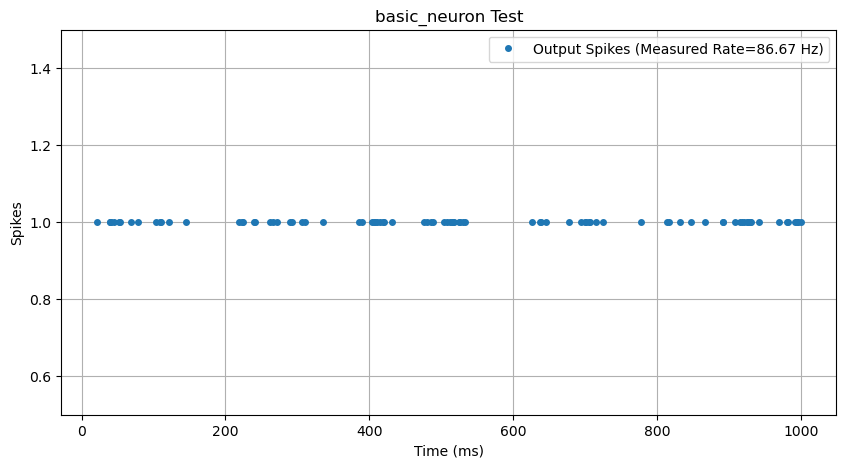

In [3]:
import nest
import matplotlib.pyplot as plt

# --- 1. Setup ---
nest.ResetKernel()

# Install the compiled module using the name you provided
try:
    nest.Install("nestmlmodule")
except nest.NESTError as e:
    print(f"Could not find nestmlmodule. Did you compile and install it?\nError: {e}")
    exit()

# Simulation parameters
sim_time = 1000.0
resolution = 1.0
nest.resolution = resolution
neuron_sim_steps = int(sim_time / resolution)

# --- 2. Create Nodes ---
# Create the neuron to be tested
# We set kp=2.0, so we expect the output rate to be double the input rate, plus the base rate.
# We set pos=True, so it should respond to positive weights.
neuron = nest.Create("basic_neuron", params={
    "kp": 2.0,
    "pos": True,
    "base_rate": 5.0, # Hz
    "buffer_size": 20.0, # ms
    "simulation_steps": neuron_sim_steps
})

# Provide a constant input rate
input_rate = 50.0 # Hz

# Use poisson_generator for a rate-based input
spike_generator = nest.Create("poisson_generator", params={
    "rate": input_rate
})

# Create a spike recorder to capture the output
spike_recorder = nest.Create("spike_recorder")

# --- 3. Connect Nodes ---
# Connect the generator to the neuron with a positive weight
nest.Connect(spike_generator, neuron, syn_spec={"weight": 1.0})

# Connect the neuron to the recorder
nest.Connect(neuron, spike_recorder)

# --- 4. Simulate ---
print(f"Simulating for {sim_time} ms...")
nest.Simulate(sim_time)
print("Simulation finished.")

# --- 5. Analyze Results ---
events = spike_recorder.events
output_spike_times = events["times"]
num_output_spikes = len(output_spike_times)

# Calculate the output firing rate (ignoring the first 100ms for the buffer to fill up)
# This gives the neuron time to reach a steady state.
steady_state_spikes = [t for t in output_spike_times if t > 100.0]
output_rate = len(steady_state_spikes) / ((sim_time - 100.0) / 1000.0)

print("\n--- Results for basic_neuron ---")
print(f"Input rate: {input_rate} Hz")

# Theoretical calculation:
# in_rate inside the neuron is defined as (1000 * abs(spike_count_in)) / buffer_size
# For a 50 Hz Poisson input over a 100ms buffer, spike_count_in will be ~50 * 0.1 = 5 spikes.
# So, in_rate = (1000 * 5) / 100 = 50 Hz.
# out_rate = base_rate + kp * in_rate = 5.0 + 2.0 * 50.0 = 105.0 Hz
expected_rate = 5.0 + 2.0 * input_rate
print(f"Expected output rate (approx.): {expected_rate:.2f} Hz")
print(f"Measured output rate: {output_rate:.2f} Hz")

# --- 6. Plot the results ---
plt.figure(figsize=(10, 5))
plt.title("basic_neuron Test")
plt.xlabel("Time (ms)")
plt.ylabel("Spikes")
plt.plot(output_spike_times, [1]*num_output_spikes, 'o', ms=4, label=f'Output Spikes (Measured Rate={output_rate:.2f} Hz)')
plt.ylim(0.5, 1.5)
plt.legend()
plt.grid(True)
plt.show()


Jun 25 18:25:44 Install [Info]: 
    loaded module nestmlmodule

Jun 25 18:25:44 correlation_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlomatrix_detector [Info]: 
    Default for delta_tau changed from 0.5 to 5 ms

Jun 25 18:25:44 correlospinmatrix_detector [Info]: 
    Default for delta_tau changed from 0.1 to 1 ms

Jun 25 18:25:44 rb_neuron [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Jun 25 18:25:44 basic_neuron [Warning]: 
    Simulation resolution has changed. Internal state and parameters of the 
    model have been reset!

Jun 25 18:25:44 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 1 ms.
Simulating...
Simulation finished.

Jun 25 18:25:44 NodeManager::prepare_nodes [Info]: 
    Preparing 12 nodes for simulation.

Jun 25 18:25:44 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 12
    Simulation time 

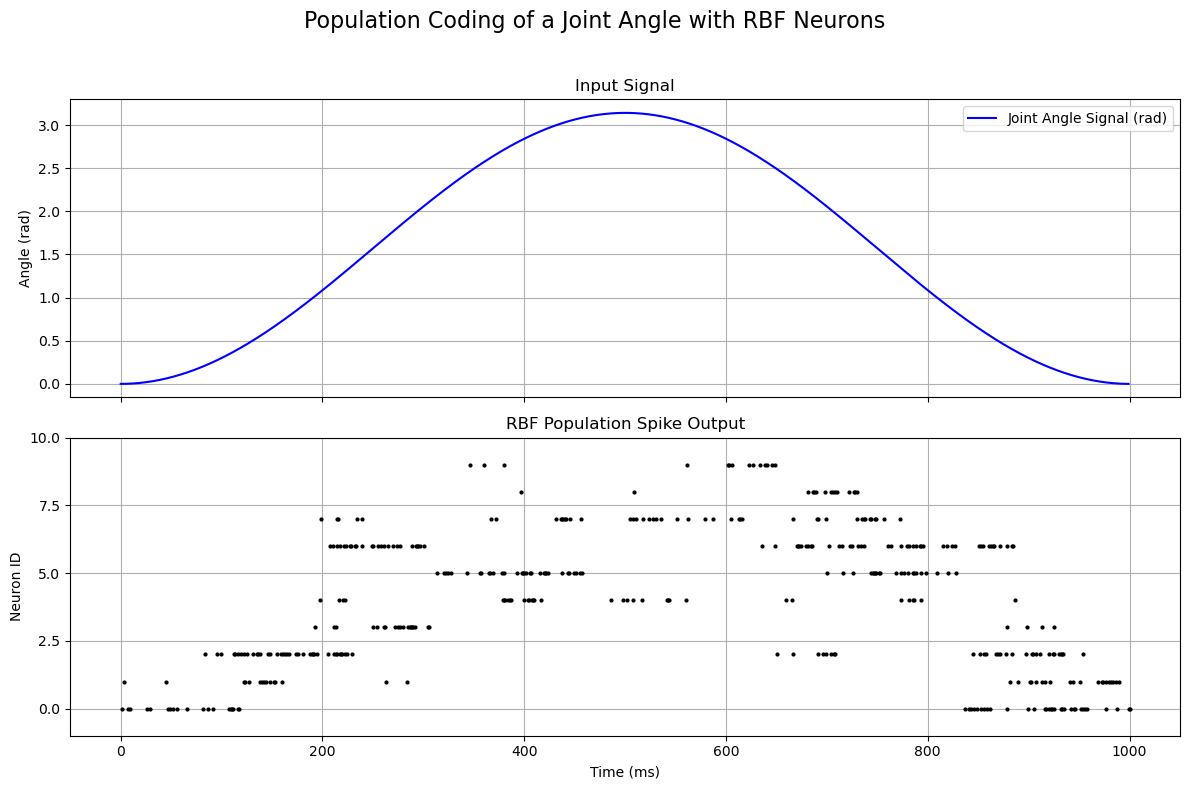

In [4]:
import nest
import matplotlib.pyplot as plt
import numpy as np

# --- 1. Setup ---
nest.ResetKernel()
try:
    nest.Install("nestmlmodule")
except nest.NESTError as e:
    print(f"Could not find nestmlmodule. Did you compile and install it?\nError: {e}")
    exit()

sim_time = 1000.0  # ms
resolution = 1.0   # ms
nest.resolution = resolution
neuron_sim_steps = int(sim_time / resolution)

# --- 2. Generate and Encode the Input Signal ---

# Time vector for the signal
# The original time vector is still useful for generating the angle signal
signal_time = np.arange(0., sim_time, resolution)

# A) Create a sample joint angle signal (a sine wave from 0 to PI)
MIN_ANGLE = 0.0
MAX_ANGLE = np.pi
angle_signal = (MAX_ANGLE - MIN_ANGLE) / 2 * (1 - np.cos(2 * np.pi * signal_time / sim_time)) + MIN_ANGLE

# B) Define the mapping from angle to firing rate
MIN_RATE = 5.0   # Hz (for MIN_ANGLE)
MAX_RATE = 100.0 # Hz (for MAX_ANGLE)

# C) Apply the linear mapping to encode the signal
rate_signal = MIN_RATE + (angle_signal - MIN_ANGLE) * (MAX_RATE - MIN_RATE) / (MAX_ANGLE - MIN_ANGLE)

# D) Create a rate time vector for the input signal
rate_time_vector = np.arange(resolution, sim_time + resolution, resolution)


# --- 3. Create the Tuned RBF Neuron Population ---
num_rbf_neurons = 10 # Number of RBF neurons
desired_rates = np.linspace(MIN_RATE, MAX_RATE, num_rbf_neurons)
rbf_params = {
    "sdev": 10.0,
    "base_rate": 0.0,
    "buffer_size": 100.0,
    "simulation_steps": neuron_sim_steps,
    "kp": 1000.0
}
rbf_population = nest.Create("rb_neuron", num_rbf_neurons, params=rbf_params)
for i, neuron in enumerate(rbf_population):
    neuron.set(desired=desired_rates[i])


# --- 4. Create Input, Connect, and Record ---

# Create an inhomogeneous Poisson generator to provide the input rates
rate_source = nest.Create("inhomogeneous_poisson_generator", params={
    'rate_times': rate_time_vector,
    'rate_values': rate_signal
})

spike_recorder = nest.Create("spike_recorder")
nest.Connect(rate_source, rbf_population, conn_spec="all_to_all", syn_spec={"weight": 1.0})
nest.Connect(rbf_population, spike_recorder, conn_spec="all_to_all")


# --- 5. Simulate and Visualize ---
print("Simulating...")
nest.Simulate(sim_time)
print("Simulation finished.")

# A) Create a figure with two subplots, sharing the x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Population Coding of a Joint Angle with RBF Neurons", fontsize=16)

# B) Plot the original continuous signal on the top subplot (using the original time for plotting)
ax1.plot(signal_time, angle_signal, 'b-', label='Joint Angle Signal (rad)')
ax1.set_ylabel("Angle (rad)")
ax1.set_title("Input Signal")
ax1.grid(True)
ax1.legend()

# C) Plot the spike raster plot of the RBF population on the bottom subplot
events = spike_recorder.events
ax2.plot(events['times'], events['senders'] - min(rbf_population.get("global_id")), 'o', ms=2, color='k')
ax2.set_xlabel("Time (ms)")
ax2.set_ylabel("Neuron ID")
ax2.set_title("RBF Population Spike Output")
ax2.set_yticks(np.linspace(0, num_rbf_neurons, 5)) # Show some ticks for Neuron IDs
ax2.set_ylim(-1, num_rbf_neurons) # Set y-axis limits neatly
ax2.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()